# Computer Vision and Advanced Machine Learning area of the project.
### Author: Hugo Iglesias Pombo (2025)
### NO2: Breast Tumor Segmentation with Attention Mechanisms and Genetic Algorithm Optimization

This notebook implements the breast tumor segmentation model described in the research paper "Explainable attention based breast tumor segmentation using a combination of UNet, ResNet, DenseNet, and EfficientNet models". We extend the original approach by adding genetic algorithm-based hyperparameter optimization and optimizing for Apple Silicon (MPS).

### 1. Setup and Environment Preparation

In this cell, we import all necessary libraries and set up our environment. We check for hardware acceleration (Apple Silicon MPS or CUDA) and set random seeds for reproducibility. We also define basic configuration settings that will be used throughout the notebook.

In [1]:
# Import required libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import random
import pygad
import warnings
import gc
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Check for available hardware
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
random.seed(seed)

# Check for GPU availability
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
random.seed(seed)

# Disable warnings
warnings.filterwarnings('ignore')

# Configuration settings
IMAGE_SIZE = (224, 224)  # Image size used in the paper
BATCH_SIZE = 16  # Will be optimized with genetic algorithm later

print("Setup complete!")

Using MPS device (Apple Silicon)
tensor([1.], device='mps:0')
Setup complete!


### 2. Loading and Configuration of the BUSI Dataset

Here we load the Breast Ultrasound Images (BUSI) dataset. We read both the images and their corresponding segmentation masks, and split them into training, validation, and test sets. We also display a sample image and mask to verify that the data is loaded correctly.

Dataset found. Loading data...
Success: 647 image-mask pairs loaded.
Train set: 517 images
Validation set: 65 images
Test set: 65 images


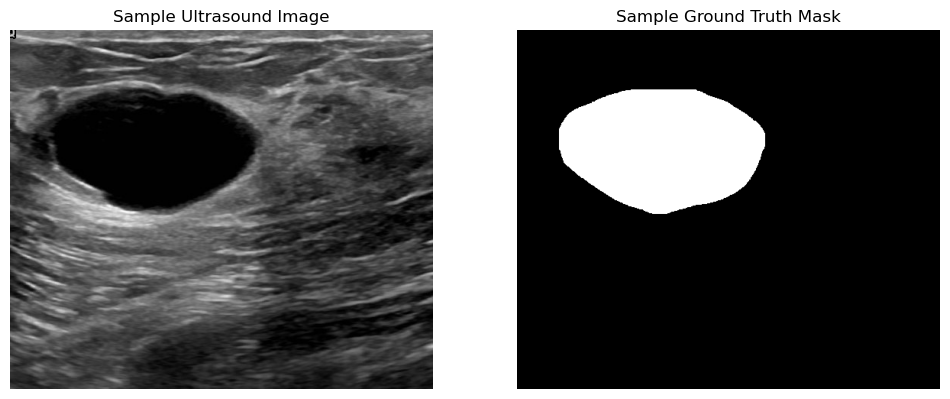

In [2]:
# Function to load and preprocess dataset
def load_dataset(dataset_path):
    """
    Load BUSI dataset images and masks, focusing on benign and malignant categories.
    Args:
        dataset_path: Path to the BUSI dataset
    Returns:
        Lists of image paths and corresponding mask paths
    """
    image_paths = []
    mask_paths = []
    for category in ['benign', 'malignant']:  # Only benign and malignant
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            print(f"Warning: {category_path} does not exist!")
            continue
        files = os.listdir(category_path)
        files_set = set(files)
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')) and '_mask' not in file:
                mask_file = file.split('.')[0] + '_mask.' + file.split('.')[-1]
                if mask_file in files_set:
                    image_paths.append(os.path.join(category_path, file))
                    mask_paths.append(os.path.join(category_path, mask_file))
                else:
                    print(f"Warning: Mask missing for image {file} in {category}")
    
    # Check final lengths
    if len(image_paths) != len(mask_paths):
        print(f"Error: {len(image_paths)} images and {len(mask_paths)} masks loaded (should be equal).")
    else:
        print(f"Success: {len(image_paths)} image-mask pairs loaded.")
    return image_paths, mask_paths

# Data paths - update this to your dataset path
dataset_path = '/Volumes/Proyecto_Hugo/breast-cancer-analysis/datasets/Dataset_BUSI_with_GT' 

# Check if dataset exists
if not os.path.exists(dataset_path):
    print("Dataset not found. Please download and extract it to the specified path.")
    print("Dataset can be downloaded from: https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset")
else:
    print("Dataset found. Loading data...")
    
    # Load dataset
    image_paths, mask_paths = load_dataset(dataset_path)
    
    # Split data into train, validation, and test sets (80%, 10%, 10%)
    train_img_paths, temp_img_paths, train_mask_paths, temp_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=seed
    )
    val_img_paths, test_img_paths, val_mask_paths, test_mask_paths = train_test_split(
        temp_img_paths, temp_mask_paths, test_size=0.5, random_state=seed
    )
    
    print(f"Train set: {len(train_img_paths)} images")
    print(f"Validation set: {len(val_img_paths)} images")
    print(f"Test set: {len(test_img_paths)} images")
    
    # Visualize a sample image and mask
    if len(image_paths) > 0:
        sample_idx = np.random.randint(0, len(train_img_paths))
        sample_img = cv2.imread(train_img_paths[sample_idx])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
        sample_mask = cv2.imread(train_mask_paths[sample_idx], cv2.IMREAD_GRAYSCALE)
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(sample_img)
        plt.title('Sample Ultrasound Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(sample_mask, cmap='gray')
        plt.title('Sample Ground Truth Mask')
        plt.axis('off')
        plt.show()

### 3. Dataset Class with Improved Preprocessing

This cell creates our dataset class with enhanced preprocessing specifically designed for ultrasound images. We use CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve the visibility of tumor boundaries. We also apply various data augmentations during training to improve model generalization. The final part displays samples of augmented images and masks.

DataLoaders ready: 33 training batches, 5 validation batches, 5 test batches.


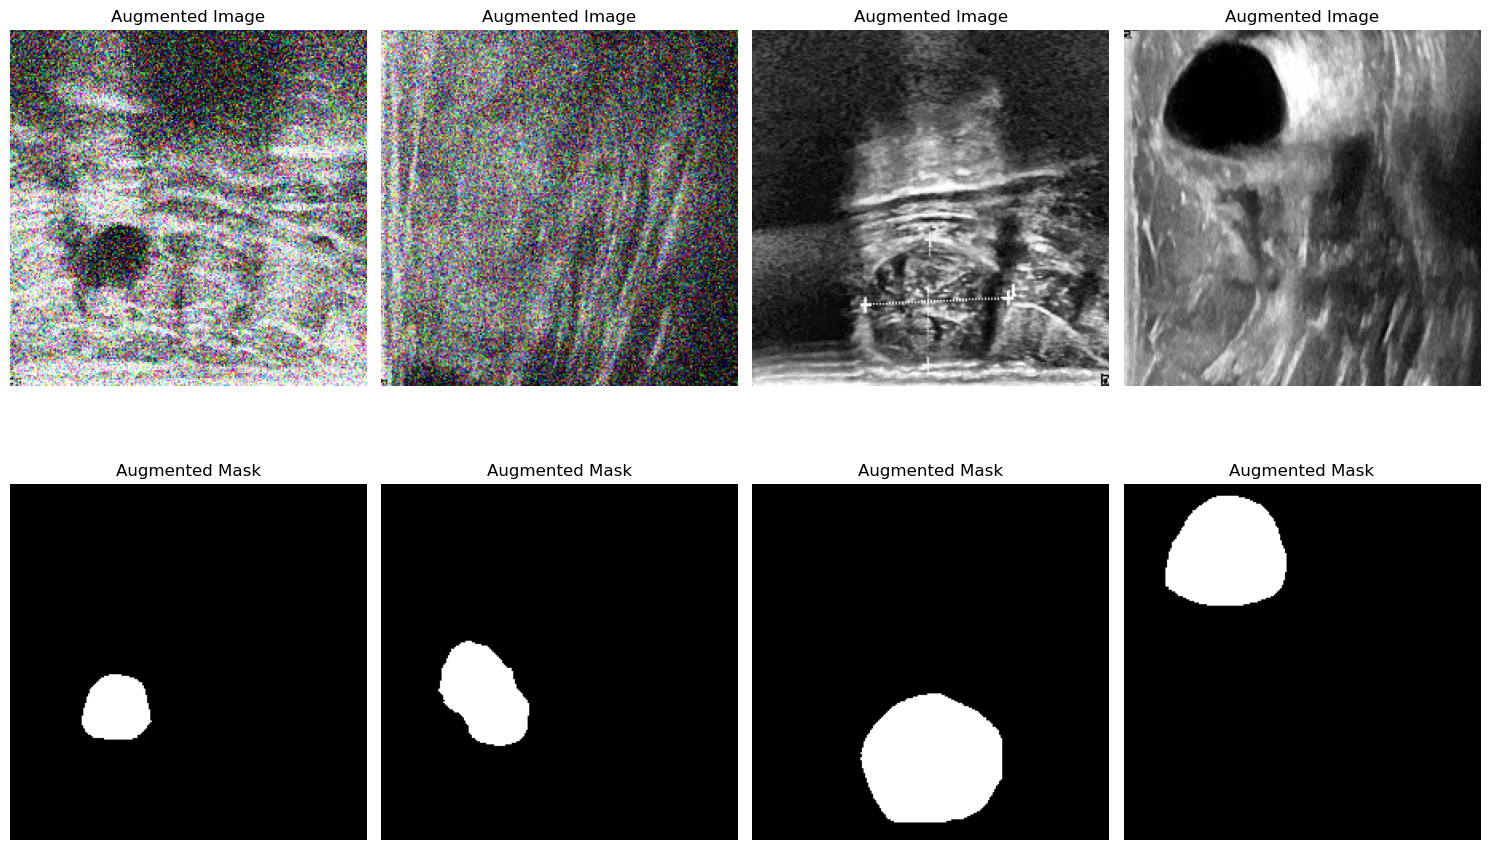

In [3]:
class BUSIDataset(Dataset):
    """
    Dataset class for Breast Ultrasound Images with enhanced preprocessing
    specifically designed for ultrasound image characteristics.
    """
    def __init__(self, image_paths, mask_paths, image_size=(224, 224), augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.augment = augment
        
        # Define transformations with specific ultrasound image enhancements
        if self.augment:
            self.transform = A.Compose([
                A.Resize(height=image_size[0], width=image_size[1]),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),
                A.GaussNoise(p=0.3),
                A.OneOf([
                    A.MotionBlur(p=0.5),
                    A.MedianBlur(blur_limit=3, p=0.5),
                    A.GaussianBlur(blur_limit=3, p=0.5),
                ], p=0.3),
                A.CLAHE(p=0.3),  # Contrast Limited Adaptive Histogram Equalization - critical for ultrasound
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ])
        else:
            self.transform = A.Compose([
                A.Resize(height=image_size[0], width=image_size[1]),
                A.CLAHE(p=1.0),  # Always apply CLAHE for non-augmented images
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image and mask
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Read image and convert to RGB
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Read mask and ensure binary
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 128).astype(np.float32)
        
        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
            # Ensure mask is in the right format for model
            mask = mask.unsqueeze(0)
        
        return image, mask

# Create Dataset objects
train_dataset = BUSIDataset(train_img_paths, train_mask_paths, image_size=IMAGE_SIZE, augment=True)
val_dataset = BUSIDataset(val_img_paths, val_mask_paths, image_size=IMAGE_SIZE, augment=False)
test_dataset = BUSIDataset(test_img_paths, test_mask_paths, image_size=IMAGE_SIZE, augment=False)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"DataLoaders ready: {len(train_loader)} training batches, {len(val_loader)} validation batches, {len(test_loader)} test batches.")

# Show a batch of augmented images
X_batch, y_batch = next(iter(train_loader))
plt.figure(figsize=(15, 10))
for i in range(min(4, X_batch.shape[0])):
    plt.subplot(2, 4, i+1)
    img = X_batch[i].permute(1, 2, 0).numpy()
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(img)
    plt.title('Augmented Image')
    plt.axis('off')
    plt.subplot(2, 4, i+5)
    mask = y_batch[i, 0, :, :].numpy()
    plt.imshow(mask, cmap='gray')
    plt.title('Augmented Mask')
    plt.axis('off')
plt.tight_layout()
plt.show()

### 4. Attention Mechanisms Implementation

This cell implements the key attention mechanisms. The Channel Attention Module helps the model focus on important feature channels, while the Spatial Attention Module highlights important spatial locations. CBAM combines both to enhance feature representation. We also implement the Non-Local Block for capturing long-range dependencies and Depthwise Separable Convolutions to reduce computational complexity.

In [4]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    """
    Channel Attention Module focuses on 'what' is important by highlighting important feature channels.
    """
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.shared_MLP = nn.Sequential(
            nn.Linear(in_planes, in_planes // ratio, bias=True),
            nn.ReLU(),
            nn.Linear(in_planes // ratio, in_planes, bias=True)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        b, c, _, _ = x.size()
        
        # Average pooling branch
        avg_out = self.avg_pool(x).view(b, c)
        avg_out = self.shared_MLP(avg_out)
        
        # Max pooling branch
        max_out = self.max_pool(x).view(b, c)
        max_out = self.shared_MLP(max_out)
        
        # Combine branches and apply sigmoid
        out = avg_out + max_out
        out = self.sigmoid(out).view(b, c, 1, 1)
        
        # Scale input feature maps
        return x * out

# Spatial Attention Module
class SpatialAttention(nn.Module):
    """
    Spatial Attention Module focuses on 'where' is important by highlighting relevant spatial locations.
    """
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Average and max pooling along channel axis
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        
        # Concatenate along channel axis
        x_cat = torch.cat([avg_out, max_out], dim=1)
        
        # Apply convolution and sigmoid
        x_out = self.conv1(x_cat)
        return x * self.sigmoid(x_out)

# CBAM Block (Channel + Spatial Attention)
class CBAM(nn.Module):
    """
    Complete CBAM block combining channel and spatial attention sequentially.
    """
    def __init__(self, in_planes, ratio=8, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
        
    def forward(self, x):
        # Apply channel attention
        out = self.channel_attention(x)
        # Apply spatial attention
        out = self.spatial_attention(out)
        return out

# Non-Local Block
class NonLocalBlock(nn.Module):
    """
    Non-Local Attention mechanism that captures long-range dependencies in images.
    """
    def __init__(self, in_channels, compression=2):
        super(NonLocalBlock, self).__init__()
        
        # Increase compression to reduce intermediate dimensions
        inter_channels = in_channels // compression
        if inter_channels == 0:
            inter_channels = 1
        
        # g path (query)
        self.g = nn.Conv2d(in_channels, inter_channels, kernel_size=1)
        # theta path (key)
        self.theta = nn.Conv2d(in_channels, inter_channels, kernel_size=1)
        # phi path (value)
        self.phi = nn.Conv2d(in_channels, inter_channels, kernel_size=1)
        # Final convolution to project back
        self.concat_project = nn.Conv2d(inter_channels, in_channels, kernel_size=1)
        # Batch normalization
        self.bn = nn.BatchNorm2d(in_channels)
        # Add spatial reduction to lower memory footprint
        self.spatial_reduction = 2

    def forward(self, x):
        batch_size, C, H, W = x.size()
        
        # Spatial reduction for memory efficiency
        H_reduced, W_reduced = H // self.spatial_reduction, W // self.spatial_reduction
        # Downsample input for attention computation
        x_reduced = F.interpolate(x, size=(H_reduced, W_reduced), mode='bilinear', align_corners=False)
        # Apply g, reshape and transpose
        g_x = self.g(x_reduced).view(batch_size, -1, H_reduced * W_reduced).permute(0, 2, 1)
        # Apply theta, reshape and transpose
        theta_x = self.theta(x_reduced).view(batch_size, -1, H_reduced * W_reduced).permute(0, 2, 1)
        # Apply phi and reshape
        phi_x = self.phi(x_reduced).view(batch_size, -1, H_reduced * W_reduced)
        
        # Process in smaller chunks to reduce memory usage
        chunk_size = min(512, H_reduced * W_reduced)
        num_chunks = (H_reduced * W_reduced + chunk_size - 1) // chunk_size
        
        # Initialize empty tensor for results
        f_div_C = torch.zeros(batch_size, H_reduced * W_reduced, H_reduced * W_reduced,
                              device=x.device, dtype=x.dtype)
        
        for i in range(num_chunks):
            row_start = i * chunk_size
            row_end = min((i + 1) * chunk_size, H_reduced * W_reduced)
            for j in range(num_chunks):
                col_start = j * chunk_size
                col_end = min((j + 1) * chunk_size, H_reduced * W_reduced)
                
                # Compute similarity for this chunk
                theta_chunk = theta_x[:, row_start:row_end, :]
                phi_chunk = phi_x[:, :, col_start:col_end]
                f_chunk = torch.matmul(theta_chunk, phi_chunk)
                
                # Apply softmax by row
                f_div_C_chunk = F.softmax(f_chunk, dim=-1)
                
                # Store result
                f_div_C[:, row_start:row_end, col_start:col_end] = f_div_C_chunk
        
        # Attention output
        y = torch.matmul(f_div_C, g_x)
        
        # Clean up to free memory
        del f_div_C, g_x, theta_x, phi_x
        gc.collect()
        
        # Reshape and permute
        y = y.permute(0, 2, 1).contiguous().view(batch_size, -1, H_reduced, W_reduced)
        
        # Upsample back to original resolution
        y = F.interpolate(y, size=(H, W), mode='bilinear', align_corners=False)
        
        # Project and add residual connection
        y = self.concat_project(y)
        y = self.bn(y)
        return x + y

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
    """
    Depthwise Separable Convolution block with ReLU6 activation
    to reduce computational complexity.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(DepthwiseSeparableConvBlock, self).__init__()
        
        # Kernel padding
        padding = kernel_size // 2
        
        # Depthwise convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels, bias=False)
        
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = F.relu6(self.bn1(self.depthwise(x)))
        x = F.relu6(self.bn2(self.pointwise(x)))
        return x

### 5. Model Architecture


This cell implements the complete model architecture. The model combines features from three different encoders (ResNet18, DenseNet121, and EfficientNet-B0) and uses skip connections to maintain spatial information. The decoder path incorporates attention mechanisms (CBAM and Non-Local) and uses depthwise separable convolutions for efficiency. The final model should have around 23.8 million parameters as reported in the paper.

In [5]:
# Encoder Block
class EncoderBlock(nn.Module):
    """
    Encoder block that uses pretrained models from torchvision
    combining ResNet18, DenseNet121, and EfficientNet-B0.
    """
    def __init__(self, pretrained=True):
        super(EncoderBlock, self).__init__()
        
        # Load models with pretrained weights
        self.resnet = torchvision.models.resnet18(pretrained=pretrained)
        self.densenet = torchvision.models.densenet121(pretrained=pretrained)
        self.efficientnet = torchvision.models.efficientnet_b0(pretrained=pretrained)
        
        # Get feature dimensions
        self.resnet_features = 512        # Final feature size of ResNet18
        self.densenet_features = 1024     # Final feature size of DenseNet121
        self.efficientnet_features = 1280  # Final feature size of EfficientNet-B0
        
        # Calculate total feature dimension
        self.out_features = self.resnet_features + self.densenet_features + self.efficientnet_features
        
        # Common output spatial size
        self.output_size = (7, 7)
        
        # Precompute settings to speed up forward pass
        self.has_initialized_forward = False
        
    def _initialize_forward(self, x):
        """
        Precompute sizes and settings to make forward pass more efficient.
        """
        # Store input size for later reference
        self.input_size = (x.size(2), x.size(3))
        
        # Run once to determine skip connection sizes
        with torch.no_grad():
            # ResNet
            resnet_features = self.resnet.conv1(x)
            resnet_features = self.resnet.bn1(resnet_features)
            resnet_features = self.resnet.relu(resnet_features)
            resnet_features = self.resnet.maxpool(resnet_features)
            
            resnet_features = self.resnet.layer1(resnet_features)
            skip1_size = (resnet_features.size(2), resnet_features.size(3))
            
            resnet_features = self.resnet.layer2(resnet_features)
            skip2_size = (resnet_features.size(2), resnet_features.size(3))
            
            resnet_features = self.resnet.layer3(resnet_features)
            skip3_size = (resnet_features.size(2), resnet_features.size(3))
            
            # Save dimensions for future reference
            self.skip1_size = skip1_size
            self.skip2_size = skip2_size
            self.skip3_size = skip3_size
        
        self.has_initialized_forward = True
        
    def forward(self, x):
        # Initialize forward settings on the first pass
        if not self.has_initialized_forward:
            self._initialize_forward(x)
        
        # Store input size
        input_size = (x.size(2), x.size(3))
        
        # Process through ResNet (extract skip connections)
        resnet_features = self.resnet.conv1(x)
        resnet_features = self.resnet.bn1(resnet_features)
        resnet_features = self.resnet.relu(resnet_features)
        resnet_features = self.resnet.maxpool(resnet_features)
        
        resnet_features = self.resnet.layer1(resnet_features)
        resnet_skip1 = resnet_features  # Skip connection 1 (56x56)
        
        resnet_features = self.resnet.layer2(resnet_features)
        resnet_skip2 = resnet_features  # Skip connection 2 (28x28)
        
        resnet_features = self.resnet.layer3(resnet_features)
        resnet_skip3 = resnet_features  # Skip connection 3 (14x14)
        
        resnet_features = self.resnet.layer4(resnet_features)  # 7x7
        
        # Process with DenseNet (only features)
        densenet_features = self.densenet.features(x)
        
        # Process with EfficientNet (only features)
        efficientnet_features = self.efficientnet.features(x)
        
        # Resize all feature maps to the same spatial size (7x7)
        if resnet_features.size(2) != self.output_size[0] or resnet_features.size(3) != self.output_size[1]:
            resnet_features = F.adaptive_avg_pool2d(resnet_features, self.output_size)

        if densenet_features.size(2) != self.output_size[0] or densenet_features.size(3) != self.output_size[1]:
            densenet_features = F.adaptive_avg_pool2d(densenet_features, self.output_size)
        
        if efficientnet_features.size(2) != self.output_size[0] or efficientnet_features.size(3) != self.output_size[1]:
            efficientnet_features = F.adaptive_avg_pool2d(efficientnet_features, self.output_size)
        
        # Concatenate features
        combined_features = torch.cat([resnet_features, densenet_features, efficientnet_features], dim=1)
        
        return combined_features, [resnet_skip1, resnet_skip2, resnet_skip3], input_size

# Decoder Block
class DecoderBlock(nn.Module):
    """
    Decoder block for the UNet architecture with attention mechanisms and depthwise separable convolutions.
    """
    def __init__(self, in_channels, out_channels, use_dsc=True, use_cbam=True, use_non_local=True):
        super(DecoderBlock, self).__init__()
        self.use_dsc = use_dsc
        self.use_cbam = use_cbam
        self.use_non_local = use_non_local
        
        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Convolution blocks
        if use_dsc:
            self.conv1 = DepthwiseSeparableConvBlock(in_channels, out_channels)
            self.conv2 = DepthwiseSeparableConvBlock(out_channels, out_channels)
        else:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU6(inplace=True)
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU6(inplace=True)
            )
        
        # Attention modules
        if use_cbam:
            self.cbam = CBAM(out_channels)
        
        if use_non_local:
            self.non_local = NonLocalBlock(out_channels)
            
    def forward(self, x, skip=None):
        x = self.upsample(x)
        
        # Concatenate with skip connection if provided
        if skip is not None:
            # Ensure the dimensions match
            if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
                x = F.interpolate(
                    x, size=(skip.size(2), skip.size(3)), mode='bilinear', align_corners=False
                )
            # Concatenate along channel dimension
            x = torch.cat([x, skip], dim=1)
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Apply attention
        if self.use_cbam:
            x = self.cbam(x)
        
        if self.use_non_local:
            # Process in smaller chunks to save memory
            batch_size = x.size(0)
            if batch_size > 1:
                # Process in chunks of 1
                outputs = []
                for i in range(batch_size):
                    outputs.append(self.non_local(x[i:i+1]))
                x = torch.cat(outputs, dim=0)
            else:
                x = self.non_local(x)
        
        return x

# Complete Multi-Encoder UNet Model
class MultiEncoderUNet(nn.Module):
    """
    UNet-based model with multiple encoders as proposed in the paper
    """
    def __init__(self, n_classes=1, use_dsc=True, use_cbam=True, use_non_local=True, pretrained=True):
        super(MultiEncoderUNet, self).__init__()
        self.n_classes = n_classes
        
        # Encoder
        self.encoder = EncoderBlock(pretrained=pretrained)
        
        # Get the output features from encoder
        encoder_features = self.encoder.out_features
        
        # Decoder path
        self.decoder4 = DecoderBlock(encoder_features, 512, use_dsc, use_cbam, use_non_local)
        self.decoder3 = DecoderBlock(512 + 256, 256, use_dsc, use_cbam, use_non_local)  # 256 from skip connection
        self.decoder2 = DecoderBlock(256 + 128, 128, use_dsc, use_cbam, use_non_local)  # 128 from skip connection
        self.decoder1 = DecoderBlock(128 + 64, 64, use_dsc, use_cbam, use_non_local)    # 64 from skip connection
        
        # Final upsampling to original input size and convolution
        self.final_upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)  # 56x56 -> 224x224
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        features, skip_connections, input_size = self.encoder(x)
        
        # Decoder with skip connections
        x = self.decoder4(features)
        x = self.decoder3(x, skip_connections[2])  # Using ResNet skip3
        x = self.decoder2(x, skip_connections[1])  # Using ResNet skip2
        x = self.decoder1(x, skip_connections[0])  # Using ResNet skip1
        
        # Final upsampling to match original input size
        x = self.final_upsample(x)
        
        # Ensure output size matches input size exactly
        if x.size(2) != input_size[0] or x.size(3) != input_size[1]:
            x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        
        # Final convolution
        x = self.final_conv(x)
        
        # Apply sigmoid for binary segmentation
        x = torch.sigmoid(x)
        
        return x

# Create a test instance of the model to check architecture
def test_model():
    print(f"Using device: {device}")
    
    # Create a small input tensor
    x = torch.randn(1, 3, 224, 224).to(device)
    
    # Create model
    model = MultiEncoderUNet(
        n_classes=1,
        use_dsc=True,
        use_cbam=True,
        use_non_local=True,
        pretrained=False  # Set to False for faster testing
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Switch to evaluation mode
    model.eval()
    
    print("Model created, running forward pass...")
    
    # Forward pass
    with torch.no_grad():
        output = model(x)
    
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print("Model test successful!")
    
    return model

# Run model test
model = test_model()

Using device: mps
Total parameters: 27,854,293
Model created, running forward pass...
Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 1, 224, 224])
Model test successful!


### 6. Loss Functions and Evaluation Metrics

Here we implement the loss functions and evaluation metrics for our model. We define both the Dice Loss, which directly optimizes segmentation overlap, and a combined BCE+Dice Loss to handle class imbalance. We also implement evaluation metrics including Dice coefficient, IoU, precision, recall, and F1 score to comprehensively evaluate segmentation performance.


In [6]:
# Define loss functions
class DiceLoss(nn.Module):
    """
    Dice Loss for binary segmentation
    """
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, predictions, targets):
        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection
        intersection = (predictions * targets).sum()
        
        # Calculate Dice coefficient
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Return Dice loss
        return 1 - dice

# Combined BCE + Dice Loss
class BCEDiceLoss(nn.Module):
    """
    Combined Binary Cross-Entropy and Dice Loss to handle class imbalance
    """
    def __init__(self, weight_bce=0.5, weight_dice=0.5, smooth=1.0):
        super(BCEDiceLoss, self).__init__()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.bce = nn.BCELoss()
        self.dice = DiceLoss(smooth=smooth)
        
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        combined_loss = self.weight_bce * bce_loss + self.weight_dice * dice_loss
        return combined_loss

# Evaluation metrics
def dice_coefficient(predictions, targets, smooth=1.0):
    """
    Calculate Dice coefficient (F1 score for segmentation)
    """
    # Convert to binary
    predictions = (predictions > 0.5).float()
    
    # Flatten predictions and targets
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    # Calculate intersection
    intersection = (predictions * targets).sum()
    
    # Calculate Dice coefficient
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    
    return dice.item()

def iou_score(predictions, targets, smooth=1.0):
    """
    Calculate IoU (Intersection over Union) score
    """
    # Convert to binary
    predictions = (predictions > 0.5).float()
    
    # Flatten predictions and targets
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    # Calculate intersection and union
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    
    # Calculate IoU
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()

def precision_recall_f1(predictions, targets):
    """
    Calculate precision, recall, and F1 score
    """
    # Convert to binary
    predictions = (predictions > 0.5).float()
    
    # Flatten predictions and targets
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    # Calculate true positives, false positives, false negatives
    tp = (predictions * targets).sum().item()
    fp = (predictions * (1 - targets)).sum().item()
    fn = ((1 - predictions) * targets).sum().item()
    
    # Calculate metrics
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    
    return precision, recall, f1

# Test the loss functions and metrics
def test_loss_functions():
    # Create sample predictions and targets
    predictions = torch.rand(2, 1, 224, 224)
    targets = torch.randint(0, 2, (2, 1, 224, 224)).float()
    
    # Calculate losses
    dice_loss = DiceLoss()(predictions, targets)
    bce_loss = nn.BCELoss()(predictions, targets)
    combined_loss = BCEDiceLoss()(predictions, targets)
    
    # Calculate metrics
    dice = dice_coefficient(predictions, targets)
    iou = iou_score(predictions, targets)
    precision, recall, f1 = precision_recall_f1(predictions, targets)
    
    print(f"Dice Loss: {dice_loss.item():.4f}")
    print(f"BCE Loss: {bce_loss.item():.4f}")
    print(f"Combined Loss: {combined_loss.item():.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"IoU Score: {iou:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Run test
test_loss_functions()

Dice Loss: 0.4989
BCE Loss: 0.9967
Combined Loss: 0.7478
Dice Coefficient: 0.5013
IoU Score: 0.3345
Precision: 0.5010
Recall: 0.5015
F1 Score: 0.5013


### 7. Training Function

This cell defines the training function with early stopping and comprehensive metric tracking. We implement gradient clipping to stabilize training and use a learning rate scheduler to adapt the learning rate based on validation performance. We also visualize the training history to monitor progress. The function returns a dictionary containing all training metrics for further analysis.

In [7]:
# Function to train the model with specific hyperparameter settings
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=15):
    """
    Train the model with comprehensive logging and early stopping
    """
    best_val_dice = 0
    patience_counter = 0
    train_losses = []
    val_dices = []
    val_ious = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    
    start_time = time.time()
    
    # Create directory for saving models
    os.makedirs('saved_models', exist_ok=True)
    
    for epoch in range(num_epochs):
        # === TRAINING PHASE ===
        model.train()
        train_loss = 0
        batch_count = 0
        
        # Use a progress bar to monitor training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for inputs, targets in progress_bar:
            # Move data to the device
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            # Zero gradients - set_to_none is more memory efficient
            optimizer.zero_grad(set_to_none=True)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({'loss': loss.item()})
            
            # Free GPU memory after every 5 batches
            if batch_count % 5 == 0:
                del outputs
                gc.collect()
        
        # Compute average training loss
        avg_train_loss = train_loss / batch_count
        train_losses.append(avg_train_loss)
        
        # === VALIDATION PHASE ===
        model.eval()
        val_dice_sum = 0
        val_iou_sum = 0
        val_precision_sum = 0
        val_recall_sum = 0
        val_f1_sum = 0
        val_batch_count = 0
        
        # No gradients accumulation in validation
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate metrics
                dice = dice_coefficient(outputs, targets)
                iou = iou_score(outputs, targets)
                precision, recall, f1 = precision_recall_f1(outputs, targets)
                
                val_dice_sum += dice
                val_iou_sum += iou
                val_precision_sum += precision
                val_recall_sum += recall
                val_f1_sum += f1
                val_batch_count += 1
                
                # Free memory
                del outputs
        
        # Compute average validation metrics
        avg_val_dice = val_dice_sum / val_batch_count
        avg_val_iou = val_iou_sum / val_batch_count
        avg_val_precision = val_precision_sum / val_batch_count
        avg_val_recall = val_recall_sum / val_batch_count
        avg_val_f1 = val_f1_sum / val_batch_count
        
        # Update history
        val_dices.append(avg_val_dice)
        val_ious.append(avg_val_iou)
        val_precisions.append(avg_val_precision)
        val_recalls.append(avg_val_recall)
        val_f1s.append(avg_val_f1)
        
        # Update the scheduler - use 1-dice since scheduler is in 'min' mode
        scheduler.step(1 - avg_val_dice)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f" Train Loss: {avg_train_loss:.4f}")
        print(f" Validation Metrics:")
        print(f" Dice: {avg_val_dice:.4f}")
        print(f" IoU: {avg_val_iou:.4f}")
        print(f" Precision: {avg_val_precision:.4f}")
        print(f" Recall: {avg_val_recall:.4f}")
        print(f" F1 Score: {avg_val_f1:.4f}")
        
        # Save the best model
        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            patience_counter = 0
            
            # Save model with metrics in filename
            model_path = f'saved_models/best_model_dice_{avg_val_dice:.4f}_epoch_{epoch+1}.pt'
            
            # Save full checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_dice': avg_val_dice,
                'val_iou': avg_val_iou,
                'val_precision': avg_val_precision,
                'val_recall': avg_val_recall,
                'val_f1': avg_val_f1
            }, model_path)
            
            print(f"Model saved with validation Dice: {best_val_dice:.4f}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
        # Clean memory after each epoch
        gc.collect()
    
    # Final information
    total_time = time.time() - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Training completed in {int(hours)}h {int(minutes)}m {int(seconds)}s")
    print(f"Best validation Dice: {best_val_dice:.4f}")
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_dices, label='Dice')
    plt.plot(val_ious, label='IoU')
    plt.plot(val_precisions, label='Precision')
    plt.plot(val_recalls, label='Recall')
    plt.plot(val_f1s, label='F1')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    return {
        'train_losses': train_losses,
        'val_dices': val_dices,
        'val_ious': val_ious,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'val_f1s': val_f1s,
        'best_val_dice': best_val_dice,
        'training_time': total_time
    }

### 8. Hyperparameter Optimization with Genetic Algorithm

This cell implements a genetic algorithm-based hyperparameter optimization framework. It systematically explores different combinations of learning rates, batch sizes, weight decay values, loss functions, and scheduler patience values to find the optimal configuration. The algorithm uses the Dice coefficient as the fitness metric and efficiently caches solutions to avoid redundant evaluations. The results are saved for later analysis.

In [ ]:
# IntensiveHyperparameterOptimizer class for finding optimal hyperparameters
class IntensiveHyperparameterOptimizer:
    """
    Genetic algorithm-based hyperparameter optimizer designed for breast tumor segmentation
    """
    def __init__(self, train_dataset, val_dataset):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.device = device
        print(f"Using device: {self.device}")

        # Search space definition - training hyperparameters
        self.learning_rates = [1e-5, 5e-5, 1e-4, 5e-4]
        self.batch_sizes = [8, 16, 24]
        self.weight_decay_options = [1e-6, 1e-5]
        self.loss_functions = ['bce', 'dice', 'combined']  # Added 'combined' for BCE+Dice
        self.optimizer_types = ['adamw']  # Fixed to 'adamw' based on paper
        self.scheduler_patience_options = [3, 4, 5]

        # Internal trackers
        self.fitness_cache = {}
        self.generation_history = []
        self.best_fitness_history = []
        self.all_evaluations = []
        self.best_overall_fitness = 0
        self.best_overall_solution = None
        self.best_model_path = None
        self.start_time = time.time()
        self.max_time_hours = 12  # Maximum 12 hours

        # Create necessary folders
        os.makedirs('hyperopt_results', exist_ok=True)
        os.makedirs('hyperopt_models', exist_ok=True)

        # Prepare datasets and logging
        self._precompute_indices()
        self._init_results_log()
        
        # Track evaluations per generation for clean output
        self.current_generation = 0
        self.completed_evals_in_generation = 0
        self.total_evals_in_generation = 0

    def _init_results_log(self):
        """Initialize a JSON file to save all evaluation logs."""
        log_file = 'hyperopt_results/evaluations_log.json'
        if not os.path.exists(log_file):
            with open(log_file, 'w') as f:
                json.dump([], f)

    def _log_evaluation(self, solution, fitness):
        """Append the current evaluation to the JSON log."""
        log_file = 'hyperopt_results/evaluations_log.json'
        entry = {
            'solution': str(solution),
            'hyperparams': self.decode_solution(solution),
            'fitness': fitness,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        self.all_evaluations.append(entry)
        try:
            with open(log_file, 'r') as f:
                log = json.load(f)
        except:
            log = []
        log.append(entry)
        with open(log_file, 'w') as f:
            json.dump(log, f, indent=2)

    def _precompute_indices(self):
        """Precompute subsets of the datasets for faster and consistent evaluation."""
        self.train_subset_size = int(0.5 * len(self.train_dataset))
        self.train_indices = random.sample(range(len(self.train_dataset)), self.train_subset_size)
        self.val_subset_size = int(0.4 * len(self.val_dataset))
        self.val_indices = random.sample(range(len(self.val_dataset)), self.val_subset_size)
        print(f"Precomputed {self.train_subset_size} training and {self.val_subset_size} validation samples")

    def decode_solution(self, solution):
        """Decode a chromosome (solution) into real hyperparameter values."""
        # Unpack solution elements
        lr_idx, bs_idx, wd_idx, loss_idx, opt_idx, sch_idx = solution

        return {
            'learning_rate': self.learning_rates[lr_idx],
            'batch_size': self.batch_sizes[bs_idx],
            'weight_decay': self.weight_decay_options[wd_idx],
            'loss_function': self.loss_functions[loss_idx],
            'optimizer_type': self.optimizer_types[opt_idx],
            'scheduler_patience': self.scheduler_patience_options[sch_idx],
            # Fixed architecture parameters based on paper
            'use_cbam': True,
            'use_non_local': True,
            'use_dsc': True
        }

    def solution_to_key(self, solution):
        """Turn a solution into a hashable key for caching fitness values."""
        return tuple(solution)

    def get_model_filename(self, solution, epoch, dice_score):
        """Create a filename for the model based on hyperparameters and validation dice."""
        params = self.decode_solution(solution)
        return (f"model_lr{params['learning_rate']}_bs{params['batch_size']}_" 
                f"{params['loss_function']}_{params['optimizer_type']}_dice{dice_score:.4f}.pt")

    # Training function with minimal output
    def _train_model_minimal(self, model, train_loader, val_loader, criterion, optimizer, scheduler, solution):
        """Train the model with minimal logging and track the best validation Dice score."""
        best_val_dice = 0
        patience_counter = 0
        patience = self.decode_solution(solution)['scheduler_patience']
        num_epochs = 15  # Increased from 10 to 15 for better convergence
        best_model_path = None

        # Use a single progress bar for the entire training process
        epochs_pbar = tqdm(range(1, num_epochs + 1), desc="Training epochs", leave=False)
        
        for epoch in epochs_pbar:
            # Training phase with minimal output
            model.train()
            train_loss = 0
            batch_count = 0
            
            for inputs, targets in train_loader:
                inputs = inputs.to(self.device, non_blocking=True)
                targets = targets.to(self.device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                train_loss += loss.item()
                batch_count += 1

            avg_train_loss = train_loss / batch_count if batch_count > 0 else 0

            # Validation phase with minimal output
            model.eval()
            val_dice_sum = 0
            val_batch_count = 0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs = inputs.to(self.device, non_blocking=True)
                    targets = targets.to(self.device, non_blocking=True)

                    outputs = model(inputs)
                    dice = dice_coefficient(outputs, targets)
                    val_dice_sum += dice
                    val_batch_count += 1

            avg_val_dice = val_dice_sum / val_batch_count if val_batch_count > 0 else 0

            # Update learning rate scheduler
            scheduler.step(1 - avg_val_dice)
            
            # Update progress bar
            epochs_pbar.set_postfix({
                'loss': f"{avg_train_loss:.4f}", 
                'dice': f"{avg_val_dice:.4f}"
            })

            # Save model if validation improves
            if avg_val_dice > best_val_dice:
                best_val_dice = avg_val_dice
                patience_counter = 0

                model_filename = self.get_model_filename(solution, epoch, avg_val_dice)
                model_path = os.path.join('hyperopt_models', model_filename)

                # Save with minimal output
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'hyperparams': self.decode_solution(solution),
                    'solution': solution,
                    'epoch': epoch,
                    'val_dice': avg_val_dice
                }, model_path)

                best_model_path = model_path
            else:
                patience_counter += 1

            # Early stopping if no improvement
            if patience_counter >= patience:
                epochs_pbar.set_description(f"Early stopping at epoch {epoch}")
                break

            # Check if exceeding time limit
            elapsed_hours = (time.time() - self.start_time) / 3600
            if elapsed_hours >= self.max_time_hours:
                epochs_pbar.set_description(f"Time limit reached at epoch {epoch}")
                break

        # Free memory
        gc.collect()

        return best_val_dice, best_model_path

    def fitness_function(self, ga_instance, solution, solution_idx):
        """Evaluate a solution by training a model and returning its best validation Dice score."""
        key = self.solution_to_key(solution)
        
        # Update counters for progress tracking
        self.completed_evals_in_generation += 1

        # Check if this solution was already evaluated
        if key in self.fitness_cache:
            # Show progress without detailed output
            print(f"Gen {self.current_generation}, Eval {self.completed_evals_in_generation}/{self.total_evals_in_generation}: "
                  f"Using cached result: {self.fitness_cache[key]:.4f}")
            return self.fitness_cache[key]

        # Decode solution into real hyperparameters
        params = self.decode_solution(solution)
        param_summary = (f"LR={params['learning_rate']}, BS={params['batch_size']}, "
                         f"Loss={params['loss_function']}, Opt={params['optimizer_type']}")
        
        # Show evaluation start with minimal info
        print(f"Gen {self.current_generation}, Eval {self.completed_evals_in_generation}/{self.total_evals_in_generation}: "
              f"Starting {param_summary}")

        try:
            # Create fixed subsets for training and validation
            train_subset = Subset(self.train_dataset, self.train_indices)
            val_subset = Subset(self.val_dataset, self.val_indices)

            train_loader = DataLoader(
                train_subset, batch_size=params['batch_size'], shuffle=True, num_workers=0, pin_memory=True
            )
            val_loader = DataLoader(
                val_subset, batch_size=params['batch_size'], shuffle=False, num_workers=0, pin_memory=True
            )

            # Create model with the fixed architectural components from the paper
            model = MultiEncoderUNet(
                n_classes=1,
                use_dsc=params['use_dsc'],
                use_cbam=params['use_cbam'],
                use_non_local=params['use_non_local'],
                pretrained=True
            ).to(self.device)

            # Choose the loss function
            if params['loss_function'] == 'bce':
                criterion = nn.BCELoss()
            elif params['loss_function'] == 'dice':
                criterion = DiceLoss()
            else:  # combined
                criterion = BCEDiceLoss(weight_bce=0.5, weight_dice=0.5)

            # Setup optimizer based on hyperparameter
            if params['optimizer_type'] == 'adam':
                optimizer = optim.Adam(
                    model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay']
                )
            elif params['optimizer_type'] == 'adamw':
                optimizer = optim.AdamW(
                    model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay']
                )
            else:  # SGD
                optimizer = optim.SGD(
                    model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'], 
                    momentum=0.9
                )

            # Setup learning rate scheduler with patience as hyperparameter
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=params['scheduler_patience'], min_lr=1e-7
            )

            # Train the model with minimal output
            best_val_dice, model_path = self._train_model_minimal(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                scheduler=scheduler,
                solution=solution
            )

            # Update the overall best model if necessary
            if best_val_dice > self.best_overall_fitness:
                self.best_overall_fitness = best_val_dice
                self.best_overall_solution = solution
                self.best_model_path = model_path
                print(f"Gen {self.current_generation}, Eval {self.completed_evals_in_generation}: "
                      f"New best model! Dice={best_val_dice:.4f}")

            # Cache and log the result with minimal output
            self.fitness_cache[key] = best_val_dice
            self._log_evaluation(solution, best_val_dice)
            
            # Show evaluation result
            print(f"Gen {self.current_generation}, Eval {self.completed_evals_in_generation}/{self.total_evals_in_generation}: "
                  f"Completed, Dice={best_val_dice:.4f}")
            
            return best_val_dice

        except Exception as e:
            # Handle errors with minimal output
            print(f"Gen {self.current_generation}, Eval {self.completed_evals_in_generation}/{self.total_evals_in_generation}: "
                  f"Error: {str(e)}")
            
            # Give a low fitness score to failed solutions
            self.fitness_cache[key] = 0.001
            self._log_evaluation(solution, 0.001)
            
            return 0.001

    def _save_optimization_status(self, ga_instance):
        """Save the current optimization status after each generation."""
        try:
            status = {
                'generation': ga_instance.generations_completed,
                'best_solution': list(ga_instance.best_solution()[0]),
                'best_fitness': float(ga_instance.best_solution()[1]),
                'best_model_path': self.best_model_path,
                'generation_history': self.generation_history,
                'best_fitness_history': [float(f) for f in self.best_fitness_history],
                'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
                'elapsed_hours': (time.time() - self.start_time) / 3600
            }
            with open('hyperopt_results/optimization_status.json', 'w') as f:
                json.dump(status, f, indent=2)
        except Exception as e:
            print(f"Warning: Could not save optimization status: {e}")

    def optimize(self, num_generations=7, sol_per_pop=7, num_parents_mating=3):
        """Run genetic algorithm to optimize training hyperparameters."""
        gene_space = [
            range(len(self.learning_rates)),
            range(len(self.batch_sizes)),
            range(len(self.weight_decay_options)),
            range(len(self.loss_functions)),
            range(len(self.optimizer_types)),
            range(len(self.scheduler_patience_options))
        ]
        
        self.start_time = time.time()

        def on_generation(ga_instance):
            """Callback executed after each generation to monitor and save progress."""
            gen_num = ga_instance.generations_completed
            self.current_generation = gen_num + 1  # Update for next generation
            self.completed_evals_in_generation = 0  # Reset counter
            self.total_evals_in_generation = ga_instance.sol_per_pop  # Set total for next gen
            
            best_solution = ga_instance.best_solution()[0]
            best_fitness = ga_instance.best_solution()[1]

            # Show generation summary
            print("\n" + "="*50)
            print(f"GENERATION {gen_num}/{num_generations} COMPLETED")
            print(f"Best fitness: {best_fitness:.4f}")
            
            best_params = self.decode_solution(best_solution)
            print("Best hyperparameters:")
            for param, value in best_params.items():
                if param not in ['use_cbam', 'use_non_local', 'use_dsc']:  # Skip architecture params
                    print(f"   {param}: {value}")
            print("="*50 + "\n")

            self.generation_history.append(gen_num)
            self.best_fitness_history.append(best_fitness)

            # Plot progress with minimal output
            plt.figure(figsize=(10, 6))
            plt.plot(self.generation_history, self.best_fitness_history, '-o', color='blue')
            plt.title('Optimization Progress')
            plt.xlabel('Generation')
            plt.ylabel('Best Fitness (Dice)')
            plt.grid(True)
            plt.savefig('hyperopt_results/optimization_progress.png')
            plt.close()

            # Save status for recovery
            self._save_optimization_status(ga_instance)

            # Memory cleanup
            gc.collect()
            
            # Check if we exceeded time limit
            elapsed_hours = (time.time() - self.start_time) / 3600
            if elapsed_hours >= self.max_time_hours:
                print(f"Time limit of {self.max_time_hours} hours reached. Stopping optimization.")
                return "stop"

        # Create GA instance with improved search settings
        ga_instance = pygad.GA(
            num_generations=num_generations,
            sol_per_pop=sol_per_pop,
            num_genes=len(gene_space),
            num_parents_mating=num_parents_mating,
            fitness_func=self.fitness_function,
            gene_space=gene_space,
            gene_type=int,
            on_generation=on_generation,
            mutation_type="adaptive",
            mutation_percent_genes=[15, 45],  # More exploration
            crossover_type="two_points",
            parent_selection_type="tournament",
            K_tournament=3,
            keep_parents=1,
            stop_criteria=["reach_0.92", "saturate_12"]  # Better stopping criteria
        )

        # Set tracking variables for first generation
        self.current_generation = 1
        self.completed_evals_in_generation = 0
        self.total_evals_in_generation = sol_per_pop

        print(f"Starting optimization with {num_generations} generations, {sol_per_pop} solutions each")
        print(f"Using paper's architecture: CBAM=True, Non-Local=True, DSC=True")
        print(f"Time limit: {self.max_time_hours} hours")

        try:
            ga_instance.run()
            print("Optimization completed successfully!")
        except KeyboardInterrupt:
            print("\nOptimization manually stopped.")
        except Exception as e:
            print(f"\nError during optimization: {e}")
            print("Attempting to recover best solution...")

        # Show final time statistics
        total_time = time.time() - self.start_time
        print(f"Total optimization time: {int(total_time//3600)}h {int((total_time%3600)//60)}m {int(total_time%60)}s")

        # Get best solution even if interrupted
        try:
            best_solution, best_fitness = ga_instance.best_solution()
            best_hyperparams = self.decode_solution(best_solution)
        except Exception:
            if self.best_overall_solution is not None:
                best_solution = self.best_overall_solution
                best_fitness = self.best_overall_fitness
                best_hyperparams = self.decode_solution(best_solution)
            else:
                print("Could not determine best solution. Using optimal values from paper.")
                best_hyperparams = {
                    'learning_rate': 1e-4,
                    'batch_size': 16,
                    'weight_decay': 1e-6,
                    'loss_function': 'combined',
                    'optimizer_type': 'adamw',
                    'scheduler_patience': 4,
                    'use_cbam': True,
                    'use_non_local': True,
                    'use_dsc': True
                }
                best_fitness = 0.0

        print("\nOPTIMIZATION RESULTS:")
        print(f"Best fitness (Dice coefficient): {best_fitness:.4f}")
        print("Best hyperparameters:")
        for param, value in best_hyperparams.items():
            if param not in ['use_cbam', 'use_non_local', 'use_dsc']:  # Skip architecture params
                print(f"  {param}: {value}")

        if self.best_model_path:
            print(f"Best model saved at: {self.best_model_path}")
        else:
            print("No best model was saved during optimization.")

        # Save final results
        try:
            results = {
                'best_hyperparams': best_hyperparams,
                'best_fitness': float(best_fitness),
                'best_model_path': self.best_model_path,
                'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
                'total_time_hours': total_time / 3600
            }
            with open('hyperopt_results/final_results.json', 'w') as f:
                json.dump(results, f, indent=2)
            print("Final results saved to 'hyperopt_results/final_results.json'")
            
            # Also save all evaluations separately to avoid huge file
            with open('hyperopt_results/all_evaluations.json', 'w') as f:
                json.dump(self.all_evaluations, f, indent=2)
        except Exception as e:
            print(f"Error saving final results: {e}")

        return best_hyperparams, self.best_model_path

# Run hyperparameter optimization
def run_optimization():
    # Free memory before starting
    gc.collect()
    
    # Output device information
    print(f"\nDevice selected for optimization: {device}")
    
    # Start optimizer with improved search settings
    print("Starting optimization of training hyperparameters...")
    optimizer = IntensiveHyperparameterOptimizer(train_dataset, val_dataset)
    best_hyperparams, best_model_path = optimizer.optimize(
        num_generations=7,  # More generations for better search
        sol_per_pop=7,      # More solutions per generation
        num_parents_mating=3 # More parents for better genetic diversity
    )

    # Load the best model if available
    if best_model_path and os.path.exists(best_model_path):
        print(f"\nLoading best model from: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            
            # Create model with paper architecture
            best_model = MultiEncoderUNet(
                n_classes=1,
                use_dsc=True,       # Fixed from paper
                use_cbam=True,      # Fixed from paper
                use_non_local=True, # Fixed from paper
                pretrained=True
            ).to(device)
            
            # Load the state dict
            best_model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Best model loaded successfully (Dice: {checkpoint['val_dice']:.4f})")
            
            # Save the model separately for easy access
            torch.save(checkpoint, 'hyperopt_models/final_best_model.pt')
            print("Best model saved as 'hyperopt_models/final_best_model.pt'")
            
            return best_model, best_hyperparams
            
        except Exception as e:
            print(f"Error loading best model: {e}")
            return None, best_hyperparams
    else:
        print("No best model available or model path not found.")
        return None, best_hyperparams

# Run optimization if executed directly
if __name__ == "__main__":
    best_model, best_hyperparams = run_optimization()


Device selected for optimization: mps
Starting optimization of training hyperparameters...
Using device: mps
Precomputed 258 training and 26 validation samples
Starting optimization with 7 generations, 7 solutions each
Using paper's architecture: CBAM=True, Non-Local=True, DSC=True
Time limit: 12 hours
Gen 1, Eval 1/7: Starting LR=0.0001, BS=16, Loss=bce, Opt=adamw


Gen 1, Eval 1: New best model! Dice=0.1327
Gen 1, Eval 1/7: Completed, Dice=0.1327
Gen 1, Eval 2/7: Starting LR=1e-05, BS=16, Loss=combined, Opt=adamw


Gen 1, Eval 2/7: Completed, Dice=0.1077
Gen 1, Eval 3/7: Starting LR=0.0005, BS=16, Loss=combined, Opt=adamw


Gen 1, Eval 3/7: Completed, Dice=0.1003
Gen 1, Eval 4/7: Starting LR=5e-05, BS=24, Loss=dice, Opt=adamw


Gen 1, Eval 4/7: Completed, Dice=0.1073
Gen 1, Eval 5/7: Starting LR=0.0001, BS=16, Loss=bce, Opt=adamw


Gen 1, Eval 5/7: Completed, Dice=0.1101
Gen 1, Eval 6/7: Starting LR=5e-05, BS=8, Loss=combined, Opt=adamw


Gen 1, Eval 6/7: Completed, Dice=0.0960
Gen 1, Eval 7/7: Starting LR=0.0005, BS=24, Loss=dice, Opt=adamw


Gen 1, Eval 7/7: Completed, Dice=0.0924
Gen 1, Eval 8/7: Using cached result: 0.1101
Gen 1, Eval 9/7: Starting LR=0.0001, BS=16, Loss=combined, Opt=adamw


Gen 1, Eval 9: New best model! Dice=0.1332
Gen 1, Eval 9/7: Completed, Dice=0.1332
Gen 1, Eval 10/7: Starting LR=1e-05, BS=16, Loss=bce, Opt=adamw


Gen 1, Eval 10/7: Completed, Dice=0.1153
Gen 1, Eval 11/7: Using cached result: 0.1101
Gen 1, Eval 12/7: Starting LR=1e-05, BS=16, Loss=bce, Opt=adamw


Gen 1, Eval 12/7: Completed, Dice=0.1119
Gen 1, Eval 13/7: Using cached result: 0.1119
Gen 1, Eval 14/7: Starting LR=0.0005, BS=16, Loss=bce, Opt=adamw


Training epochs:  47%|████▋     | 7/15 [09:33<10:58, 82.25s/it, loss=0.2654, dice=0.1089]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x121299370>>
Traceback (most recent call last):
  File "/Users/hugo/miniconda3/envs/att-unet-v2/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


### 9. Train with Optimal Hyperparameters

This cell implements a function to train the model with the optimal hyperparameters, either from the genetic algorithm or from the paper. The hyperparameters from the paper have been shown to achieve a Dice score of 0.614, and using these settings directly should help achieve similar results without the need for a lengthy hyperparameter search.

In [9]:
# Use optimal hyperparameters from paper or genetic algorithm
def train_with_optimal_hyperparameters(hyperparams=None):
    """
    Train the model with optimal hyperparameters from the paper or genetic algorithm
    """
    # Use paper's optimal hyperparameters if none provided
    if hyperparams is None:
        hyperparams = {
            'learning_rate': 1e-4,
            'batch_size': 16,
            'weight_decay': 1e-6,
            'loss_function': 'combined',  # BCE+Dice Loss
            'optimizer_type': 'adamw',
            'scheduler_patience': 4,
            'use_dsc': True,
            'use_cbam': True,
            'use_non_local': True
        }
    
    print("Training with hyperparameters:")
    for param, value in hyperparams.items():
        print(f"  {param}: {value}")
    
    # Create DataLoaders with optimal batch size
    train_loader = DataLoader(
        train_dataset,
        batch_size=hyperparams['batch_size'],
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=hyperparams['batch_size'],
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    # Create model with architecture from paper
    model = MultiEncoderUNet(
        n_classes=1,
        use_dsc=hyperparams['use_dsc'],
        use_cbam=hyperparams['use_cbam'],
        use_non_local=hyperparams['use_non_local'],
        pretrained=True
    ).to(device)
    
    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Choose loss function
    if hyperparams['loss_function'] == 'bce':
        criterion = nn.BCELoss()
    elif hyperparams['loss_function'] == 'dice':
        criterion = DiceLoss()
    else:  # combined
        criterion = BCEDiceLoss(weight_bce=0.5, weight_dice=0.5)
    
    # Choose optimizer
    if hyperparams['optimizer_type'] == 'adam':
        optimizer = optim.Adam(
            model.parameters(),
            lr=hyperparams['learning_rate'],
            weight_decay=hyperparams['weight_decay']
        )
    elif hyperparams['optimizer_type'] == 'adamw':
        optimizer = optim.AdamW(
            model.parameters(),
            lr=hyperparams['learning_rate'],
            weight_decay=hyperparams['weight_decay']
        )
    else:  # SGD
        optimizer = optim.SGD(
            model.parameters(),
            lr=hyperparams['learning_rate'],
            weight_decay=hyperparams['weight_decay'],
            momentum=0.9
        )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=hyperparams['scheduler_patience'],
        min_lr=1e-7
    )
    
    # Train the model
    print("Starting training...")
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=50,      # Train for up to 50 epochs
        patience=15         # Early stopping after 15 epochs without improvement
    )
    
    return model, history

# Run training with optimal hyperparameters
if __name__ == "__main__":
    # You can use the hyperparameters from genetic algorithm or paper
    # best_model, best_hyperparams = run_optimization()
    # model, history = train_with_optimal_hyperparameters(best_hyperparams)
    
    # Or directly use optimal values from paper
    model, history = train_with_optimal_hyperparameters()
    
    print(f"Best validation Dice: {history['best_val_dice']:.4f}")

Training with hyperparameters:
  learning_rate: 0.0001
  batch_size: 16
  weight_decay: 1e-06
  loss_function: combined
  optimizer_type: adamw
  scheduler_patience: 4
  use_dsc: True
  use_cbam: True
  use_non_local: True
Total parameters: 27,854,293
Starting training...


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.80s/it]


Epoch 1/50:
 Train Loss: 0.7514
 Validation Metrics:
 Dice: 0.1429
 IoU: 0.0776
 Precision: 0.0778
 Recall: 0.9706
 F1 Score: 0.1429
Model saved with validation Dice: 0.1429


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


Epoch 2/50:
 Train Loss: 0.7389
 Validation Metrics:
 Dice: 0.1045
 IoU: 0.0563
 Precision: 0.0567
 Recall: 0.7288
 F1 Score: 0.1045


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


Epoch 3/50:
 Train Loss: 0.7137
 Validation Metrics:
 Dice: 0.1241
 IoU: 0.0663
 Precision: 0.0677
 Recall: 0.8391
 F1 Score: 0.1241


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.80s/it]


Epoch 4/50:
 Train Loss: 0.6739
 Validation Metrics:
 Dice: 0.0764
 IoU: 0.0406
 Precision: 0.0462
 Recall: 0.2437
 F1 Score: 0.0764


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


Epoch 5/50:
 Train Loss: 0.6262
 Validation Metrics:
 Dice: 0.1306
 IoU: 0.0703
 Precision: 0.0801
 Recall: 0.4328
 F1 Score: 0.1306


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


Epoch 6/50:
 Train Loss: 0.5956
 Validation Metrics:
 Dice: 0.1104
 IoU: 0.0589
 Precision: 0.0631
 Recall: 0.4996
 F1 Score: 0.1104


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


Epoch 7/50:
 Train Loss: 0.5671
 Validation Metrics:
 Dice: 0.1431
 IoU: 0.0773
 Precision: 0.0788
 Recall: 0.8710
 F1 Score: 0.1431
Model saved with validation Dice: 0.1431


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


Epoch 8/50:
 Train Loss: 0.5432
 Validation Metrics:
 Dice: 0.0816
 IoU: 0.0430
 Precision: 0.0474
 Recall: 0.3494
 F1 Score: 0.0815


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


Epoch 9/50:
 Train Loss: 0.5407
 Validation Metrics:
 Dice: 0.1178
 IoU: 0.0628
 Precision: 0.0649
 Recall: 0.7153
 F1 Score: 0.1178


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


Epoch 10/50:
 Train Loss: 0.5191
 Validation Metrics:
 Dice: 0.1304
 IoU: 0.0702
 Precision: 0.0717
 Recall: 0.8065
 F1 Score: 0.1304


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


Epoch 11/50:
 Train Loss: 0.5088
 Validation Metrics:
 Dice: 0.0851
 IoU: 0.0450
 Precision: 0.0485
 Recall: 0.4432
 F1 Score: 0.0850


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


Epoch 12/50:
 Train Loss: 0.4988
 Validation Metrics:
 Dice: 0.1308
 IoU: 0.0703
 Precision: 0.0719
 Recall: 0.8064
 F1 Score: 0.1308


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


Epoch 13/50:
 Train Loss: 0.4799
 Validation Metrics:
 Dice: 0.1315
 IoU: 0.0708
 Precision: 0.0733
 Recall: 0.7330
 F1 Score: 0.1315


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


Epoch 14/50:
 Train Loss: 0.4827
 Validation Metrics:
 Dice: 0.1212
 IoU: 0.0647
 Precision: 0.0670
 Recall: 0.7258
 F1 Score: 0.1212


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


Epoch 15/50:
 Train Loss: 0.4657
 Validation Metrics:
 Dice: 0.1222
 IoU: 0.0654
 Precision: 0.0696
 Recall: 0.6027
 F1 Score: 0.1222


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


Epoch 16/50:
 Train Loss: 0.4579
 Validation Metrics:
 Dice: 0.1319
 IoU: 0.0708
 Precision: 0.0723
 Recall: 0.8202
 F1 Score: 0.1319


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


Epoch 17/50:
 Train Loss: 0.4520
 Validation Metrics:
 Dice: 0.0990
 IoU: 0.0529
 Precision: 0.0549
 Recall: 0.6002
 F1 Score: 0.0990


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


Epoch 18/50:
 Train Loss: 0.4406
 Validation Metrics:
 Dice: 0.1367
 IoU: 0.0738
 Precision: 0.0746
 Recall: 0.9055
 F1 Score: 0.1367


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


Epoch 19/50:
 Train Loss: 0.4471
 Validation Metrics:
 Dice: 0.1431
 IoU: 0.0774
 Precision: 0.0793
 Recall: 0.8156
 F1 Score: 0.1430


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


Epoch 20/50:
 Train Loss: 0.4496
 Validation Metrics:
 Dice: 0.1370
 IoU: 0.0739
 Precision: 0.0764
 Recall: 0.8226
 F1 Score: 0.1370


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 21/50:
 Train Loss: 0.4321
 Validation Metrics:
 Dice: 0.1315
 IoU: 0.0707
 Precision: 0.0721
 Recall: 0.8328
 F1 Score: 0.1315


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.82s/it]


Epoch 22/50:
 Train Loss: 0.4433
 Validation Metrics:
 Dice: 0.1444
 IoU: 0.0782
 Precision: 0.0804
 Recall: 0.8143
 F1 Score: 0.1444
Model saved with validation Dice: 0.1444


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 23/50:
 Train Loss: 0.4360
 Validation Metrics:
 Dice: 0.1014
 IoU: 0.0542
 Precision: 0.0570
 Recall: 0.5604
 F1 Score: 0.1013


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 24/50:
 Train Loss: 0.4348
 Validation Metrics:
 Dice: 0.1401
 IoU: 0.0757
 Precision: 0.0785
 Recall: 0.8283
 F1 Score: 0.1401


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


Epoch 25/50:
 Train Loss: 0.4143
 Validation Metrics:
 Dice: 0.1063
 IoU: 0.0571
 Precision: 0.0590
 Recall: 0.6575
 F1 Score: 0.1063


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


Epoch 26/50:
 Train Loss: 0.4272
 Validation Metrics:
 Dice: 0.1382
 IoU: 0.0746
 Precision: 0.0760
 Recall: 0.8461
 F1 Score: 0.1382


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.80s/it]


Epoch 27/50:
 Train Loss: 0.4238
 Validation Metrics:
 Dice: 0.1363
 IoU: 0.0735
 Precision: 0.0748
 Recall: 0.8782
 F1 Score: 0.1363


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


Epoch 28/50:
 Train Loss: 0.4217
 Validation Metrics:
 Dice: 0.0999
 IoU: 0.0535
 Precision: 0.0549
 Recall: 0.6459
 F1 Score: 0.0998


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


Epoch 29/50:
 Train Loss: 0.4250
 Validation Metrics:
 Dice: 0.1333
 IoU: 0.0717
 Precision: 0.0725
 Recall: 0.8948
 F1 Score: 0.1333


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


Epoch 30/50:
 Train Loss: 0.4051
 Validation Metrics:
 Dice: 0.1005
 IoU: 0.0538
 Precision: 0.0559
 Recall: 0.6037
 F1 Score: 0.1004


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


Epoch 31/50:
 Train Loss: 0.4130
 Validation Metrics:
 Dice: 0.1362
 IoU: 0.0734
 Precision: 0.0745
 Recall: 0.8696
 F1 Score: 0.1362


Validation: 100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


Epoch 32/50:
 Train Loss: 0.3988
 Validation Metrics:
 Dice: 0.1019
 IoU: 0.0547
 Precision: 0.0575
 Recall: 0.5191
 F1 Score: 0.1019


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.80s/it]


Epoch 33/50:
 Train Loss: 0.4073
 Validation Metrics:
 Dice: 0.1048
 IoU: 0.0565
 Precision: 0.0583
 Recall: 0.5950
 F1 Score: 0.1048


Validation: 100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


Epoch 34/50:
 Train Loss: 0.3946
 Validation Metrics:
 Dice: 0.1314
 IoU: 0.0705
 Precision: 0.0723
 Recall: 0.8118
 F1 Score: 0.1314


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.87s/it]


Epoch 35/50:
 Train Loss: 0.4130
 Validation Metrics:
 Dice: 0.1454
 IoU: 0.0787
 Precision: 0.0803
 Recall: 0.8124
 F1 Score: 0.1454
Model saved with validation Dice: 0.1454


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


Epoch 36/50:
 Train Loss: 0.4094
 Validation Metrics:
 Dice: 0.1401
 IoU: 0.0757
 Precision: 0.0772
 Recall: 0.7973
 F1 Score: 0.1401


Validation: 100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


Epoch 37/50:
 Train Loss: 0.4020
 Validation Metrics:
 Dice: 0.1212
 IoU: 0.0647
 Precision: 0.0673
 Recall: 0.7571
 F1 Score: 0.1212


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 38/50:
 Train Loss: 0.4071
 Validation Metrics:
 Dice: 0.1277
 IoU: 0.0686
 Precision: 0.0698
 Recall: 0.8180
 F1 Score: 0.1277


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.82s/it]


Epoch 39/50:
 Train Loss: 0.4045
 Validation Metrics:
 Dice: 0.1362
 IoU: 0.0734
 Precision: 0.0747
 Recall: 0.8492
 F1 Score: 0.1362


Validation: 100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


Epoch 40/50:
 Train Loss: 0.4041
 Validation Metrics:
 Dice: 0.1309
 IoU: 0.0703
 Precision: 0.0710
 Recall: 0.9288
 F1 Score: 0.1309


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 41/50:
 Train Loss: 0.4163
 Validation Metrics:
 Dice: 0.1296
 IoU: 0.0698
 Precision: 0.0713
 Recall: 0.7799
 F1 Score: 0.1296


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


Epoch 42/50:
 Train Loss: 0.4218
 Validation Metrics:
 Dice: 0.1489
 IoU: 0.0810
 Precision: 0.0818
 Recall: 0.8985
 F1 Score: 0.1489
Model saved with validation Dice: 0.1489


Validation: 100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


Epoch 43/50:
 Train Loss: 0.3906
 Validation Metrics:
 Dice: 0.1392
 IoU: 0.0750
 Precision: 0.0769
 Recall: 0.8445
 F1 Score: 0.1392


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.82s/it]


Epoch 44/50:
 Train Loss: 0.3975
 Validation Metrics:
 Dice: 0.1405
 IoU: 0.0758
 Precision: 0.0774
 Recall: 0.8369
 F1 Score: 0.1405


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.87s/it]


Epoch 45/50:
 Train Loss: 0.4053
 Validation Metrics:
 Dice: 0.1394
 IoU: 0.0751
 Precision: 0.0769
 Recall: 0.8419
 F1 Score: 0.1394


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


Epoch 46/50:
 Train Loss: 0.3961
 Validation Metrics:
 Dice: 0.1495
 IoU: 0.0810
 Precision: 0.0830
 Recall: 0.8419
 F1 Score: 0.1495
Model saved with validation Dice: 0.1495


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


Epoch 47/50:
 Train Loss: 0.4009
 Validation Metrics:
 Dice: 0.1113
 IoU: 0.0600
 Precision: 0.0611
 Recall: 0.6865
 F1 Score: 0.1113


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


Epoch 48/50:
 Train Loss: 0.3941
 Validation Metrics:
 Dice: 0.1102
 IoU: 0.0595
 Precision: 0.0603
 Recall: 0.7040
 F1 Score: 0.1101


Epoch 49:  30%|███       | 10/33 [00:49<01:54,  4.97s/it, loss=0.62]


error: OpenCV(4.11.0) /Users/runner/miniforge3/conda-bld/libopencv_1745417832043/work/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


### 10. Grad-CAM Visualization and Model Evaluation

This cell implements Grad-CAM visualization to show where the model is focusing when making predictions. It also contains a comprehensive evaluation function that calculates various metrics on the test set and visualizes the results. The Grad-CAM overlay helps to verify that the model is focusing on the correct tumor regions, which is crucial for the interpretability of the model.

In [ ]:
# Grad-CAM implementation for visualization
class GradCAM:
    """
    Gradient-weighted Class Activation Mapping for visualizing
    model focus areas during segmentation
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def generate(self, input_image):
        # Forward pass
        model_output = self.model(input_image)
        
        # Target for backprop
        self.model.zero_grad()
        
        # Use the output directly for segmentation (no class selection needed)
        model_output.backward(torch.ones_like(model_output))
        
        # Global average pooling of gradients
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Weighted combination of forward activation maps
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        
        # Apply ReLU to focus on features that have a positive influence
        cam = F.relu(cam)
        
        # Normalize the CAM
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)
        cam_min, cam_max = cam.min(), cam.max()
        if cam_max > cam_min:
            cam = (cam - cam_min) / (cam_max - cam_min)
        
        return cam

# Function to evaluate model on test set
def evaluate_model(model, test_loader):
    """
    Evaluate model on test set and visualize results using Grad-CAM
    """
    # Initialize Grad-CAM with the last convolution layer
    grad_cam = GradCAM(model, model.decoder1.conv2)
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize metrics
    metrics = {
        'dice': [], 'iou': [], 'precision': [], 'recall': [], 'f1': []
    }
    
    # Create directory for results
    os.makedirs('results', exist_ok=True)
    
    # Select at least 10 random samples for visualization
    num_samples = min(10, len(test_loader))
    visualize_indices = np.random.choice(len(test_loader), num_samples, replace=False)
    
    # Evaluate all test samples
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(test_loader, desc="Evaluating")):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate metrics
            dice = dice_coefficient(outputs, targets)
            iou = iou_score(outputs, targets)
            precision, recall, f1 = precision_recall_f1(outputs, targets)
            
            metrics['dice'].append(dice)
            metrics['iou'].append(iou)
            metrics['precision'].append(precision)
            metrics['recall'].append(recall)
            metrics['f1'].append(f1)
            
            # Visualize selected samples
            if i in visualize_indices:
                # Generate Grad-CAM
                model.zero_grad()
                outputs_for_cam = model(inputs)
                cam = grad_cam.generate(inputs)
                
                # Convert to numpy for visualization
                input_np = inputs[0].cpu().permute(1, 2, 0).numpy()
                # Unnormalize
                input_np = input_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                input_np = np.clip(input_np, 0, 1)
                
                target_np = targets[0, 0].cpu().numpy()
                output_np = (outputs[0, 0].cpu().numpy() > 0.5).astype(np.float32)
                cam_np = cam[0, 0].cpu().numpy()
                
                # Create heatmap overlay
                heatmap = cv2.applyColorMap(np.uint8(255 * cam_np), cv2.COLORMAP_JET)
                heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
                heatmap = np.float32(heatmap) / 255.0
                
                # Create overlay
                overlay = 0.7 * input_np + 0.3 * heatmap
                
                # Calculate ROC curve
                fpr, tpr, _ = roc_curve(
                    targets[0, 0].cpu().numpy().flatten(),
                    outputs[0, 0].cpu().numpy().flatten()
                )
                roc_auc = auc(fpr, tpr)
                
                # Plot results
                plt.figure(figsize=(15, 10))
                
                plt.subplot(2, 3, 1)
                plt.imshow(input_np)
                plt.title('Original Image')
                plt.axis('off')
                
                plt.subplot(2, 3, 2)
                plt.imshow(target_np, cmap='gray')
                plt.title('Ground Truth')
                plt.axis('off')
                
                plt.subplot(2, 3, 3)
                plt.imshow(output_np, cmap='gray')
                plt.title(f'Prediction (Dice: {dice:.4f})')
                plt.axis('off')
                
                plt.subplot(2, 3, 4)
                plt.imshow(cam_np, cmap='jet')
                plt.title('Grad-CAM Attention Map')
                plt.axis('off')
                
                plt.subplot(2, 3, 5)
                plt.imshow(overlay)
                plt.title('Grad-CAM Overlay')
                plt.axis('off')
                
                plt.subplot(2, 3, 6)
                plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve')
                plt.legend(loc='lower right')
                
                plt.tight_layout()
                plt.savefig(f'results/sample_{i}_dice_{dice:.4f}.png')
                plt.close()
    
    # Calculate and display overall test metrics
    avg_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
    
    print("\nTest Set Performance:")
    print(f" Average Dice: {avg_metrics['dice']:.4f}")
    print(f" Average IoU: {avg_metrics['iou']:.4f}")
    print(f" Average Precision: {avg_metrics['precision']:.4f}")
    print(f" Average Recall: {avg_metrics['recall']:.4f}")
    print(f" Average F1 Score: {avg_metrics['f1']:.4f}")
    
    # Visualize overall metrics
    plt.figure(figsize=(10, 6))
    metrics_names = list(avg_metrics.keys())
    values = list(avg_metrics.values())
    
    bars = plt.bar(metrics_names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    
    # Add value labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center')
    
    plt.ylim(0, 1.0)
    plt.title('Overall Performance on Test Set')
    plt.ylabel('Score')
    plt.savefig('results/overall_test_metrics.png')
    plt.show()
    
    return avg_metrics

# Use this function to evaluate your best model
if __name__ == "__main__":
    # Load best model
    best_model_path = 'saved_models/best_model_dice_X.XXXX_epoch_XX.pt'  # Update with your best model path
    
    if os.path.exists(best_model_path):
        # Create model
        model = MultiEncoderUNet(
            n_classes=1,
            use_dsc=True,
            use_cbam=True,
            use_non_local=True,
            pretrained=False  # Not needed for evaluation
        ).to(device)
        
        # Load state dict
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model with validation Dice: {checkpoint['val_dice']:.4f}")
        
        # Create test loader with batch size 1 for visualization
        test_loader = DataLoader(
            test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=1,
            pin_memory=True
        )
        
        # Evaluate model
        metrics = evaluate_model(model, test_loader)
    else:
        print(f"Model file not found: {best_model_path}")
        print("Please train a model first or provide the correct path to the best model.")